In [1]:
# run sot demo
import mmcv
import tempfile 
import os
import numpy as np
from mmtrack.apis import inference_sot, init_model

def get_iou(ground_truth, pred):
    # coordinates of the area of intersection.
    ix1 = np.maximum(ground_truth[0], pred[0])
    iy1 = np.maximum(ground_truth[1], pred[1])
    ix2 = np.minimum(ground_truth[2], pred[2])
    iy2 = np.minimum(ground_truth[3], pred[3])
     
    # Intersection height and width.
    i_height = np.maximum(iy2 - iy1 + 1, np.array(0.))
    i_width = np.maximum(ix2 - ix1 + 1, np.array(0.))
     
    area_of_intersection = i_height * i_width
     
    # Ground Truth dimensions.
    gt_height = ground_truth[3] - ground_truth[1] + 1
    gt_width = ground_truth[2] - ground_truth[0] + 1
     
    # Prediction dimensions.
    pd_height = pred[3] - pred[1] + 1
    pd_width = pred[2] - pred[0] + 1
     
    area_of_union = gt_height * gt_width + pd_height * pd_width - area_of_intersection
     
    iou = area_of_intersection / area_of_union
     
    return iou

def inferencia(dataset):
    os.system('ffmpeg -f image2 -r 60 -i ./' + dataset + '/img/%05d.jpg -vcodec mpeg4 -y ./' + dataset + '.mp4')
    sot_config = './mmtracking/configs/sot/siamese_rpn/siamese_rpn_r50_20e_lasot.py'
    sot_checkpoint = './siamese_rpn_r50_1x_lasot_20211203_151612-da4b3c66.pth'
    input_video = './' + dataset + '.mp4'
    bb_file = './' + dataset + '/groundtruth_rect.txt'
    # Reading the file
    with open(bb_file) as iostream:
        content = iostream.read()
    bbox = dict()
    for line in content.split("\n"):
        frame, xmin, ymin, xmax, ymax, isLost = line.split(",")
        bbox[frame] = dict([('x1', float(xmin)), ('y1', float(ymin)), ('x2', float(xmax)), ('y2', float(ymax))])
    # build the model from a config file and a checkpoint file
    sot_model = init_model(sot_config, sot_checkpoint, device='cpu')
    init_bbox = [bbox['1']['x1'], bbox['1']['y1'], bbox['1']['x1'] + bbox['1']['x2'], bbox['1']['y1'] + bbox['1']['y2']]
    imgs = mmcv.VideoReader(input_video)
    prog_bar = mmcv.ProgressBar(len(imgs))
    out_dir = tempfile.TemporaryDirectory()
    out_path = out_dir.name
    error = list()
    for i, img in enumerate(imgs):
        result = inference_sot(sot_model, img, init_bbox, frame_id=i)
        #ground_truth bbox
        bbox_gt = np.array([bbox[str(i+1)]['x1'], bbox[str(i+1)]['y1'], bbox[str(i+1)]['x1'] + bbox[str(i+1)]['x2'], bbox[str(i+1)]['y2'] + bbox[str(i+1)]['y1']], dtype=np.float32)
        bbox_pr = np.array([result['track_bboxes'][0], result['track_bboxes'][1], result['track_bboxes'][2], result['track_bboxes'][3]], dtype=np.float32)
        #predicted bbox
        #intersection over union 
        io = get_iou(bbox_gt, bbox_pr)
        error.append(io)
        sot_model.show_result(
                img,
                result,
                wait_time=int(1000. / imgs.fps),
                out_file=f'{out_path}/{i:06d}.jpg')
        
        prog_bar.update()

    output = './' + dataset + 'inference.mp4'
    print(f'\n making the output video at {output} with a FPS of {imgs.fps}')
    mmcv.frames2video(out_path, output, fps=imgs.fps, fourcc='mp4v')
    out_dir.cleanup()
    return error

/Users/jiabowang/miniconda3/envs/vc/lib/python3.7/site-packages/mmcv/__init__.py:21: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  'On January 1, 2023, MMCV will release v2.0.0, in which it will remove '


In [2]:
error_moto = inferencia('MotorcycleChase')

2023-06-20 12:30:37,105 - mmcv - INFO - initialize SOTResNet with init_cfg {'type': 'Pretrained', 'checkpoint': 'https://download.openmmlab.com/mmtracking/pretrained_weights/sot_resnet50.model'}
2023-06-20 12:30:37,106 - mmcv - INFO - load model from: https://download.openmmlab.com/mmtracking/pretrained_weights/sot_resnet50.model
2023-06-20 12:30:37,107 - mmcv - INFO - load checkpoint from http path: https://download.openmmlab.com/mmtracking/pretrained_weights/sot_resnet50.model


load checkpoint from local path: ./siamese_rpn_r50_1x_lasot_20211203_151612-da4b3c66.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 600/600, 2.8 task/s, elapsed: 214s, ETA:     0s
 making the output video at ./MotorcycleChaseinference.mp4 with a FPS of 30.0
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 600/600, 88.2 task/s, elapsed: 7s, ETA:     0s


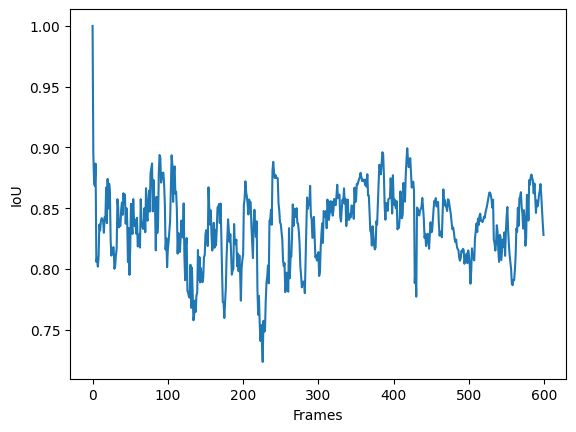

0.7235811924989695


In [5]:
from matplotlib import pyplot as plt
plt.plot(error_moto)
plt.xlabel("Frames")
plt.ylabel("IoU")
plt.show()
print(min(error_moto))

ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with clang version 10.0.0
  configuration: --prefix=/Users/distiller/miniconda3/conda-bld/ffmpeg_1597180257571/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold --cc=x86_64-apple-darwin13.4.0-clang --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
In

load checkpoint from local path: ./siamese_rpn_r50_1x_lasot_20211203_151612-da4b3c66.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 600/600, 2.4 task/s, elapsed: 255s, ETA:     0s
 making the output video at ./Boatinference.mp4 with a FPS of 60.0
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 600/600, 81.8 task/s, elapsed: 7s, ETA:     0s


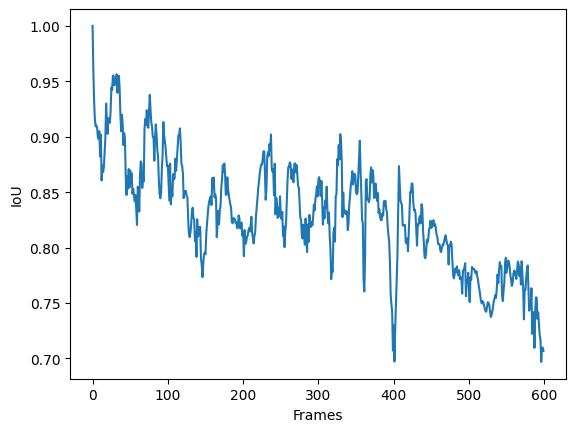

0.696781914707618


In [12]:
error_boat = inferencia('Boat')
from matplotlib import pyplot as plt
plt.plot(error_boat)
plt.xlabel("Frames")
plt.ylabel("IoU")
plt.show()
print(min(error_boat))

ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with clang version 10.0.0
  configuration: --prefix=/Users/distiller/miniconda3/conda-bld/ffmpeg_1597180257571/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold --cc=x86_64-apple-darwin13.4.0-clang --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
In

load checkpoint from local path: ./siamese_rpn_r50_1x_lasot_20211203_151612-da4b3c66.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 600/600, 2.9 task/s, elapsed: 204s, ETA:     0s
 making the output video at ./Drone3inference.mp4 with a FPS of 60.0
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 600/600, 73.4 task/s, elapsed: 8s, ETA:     0s


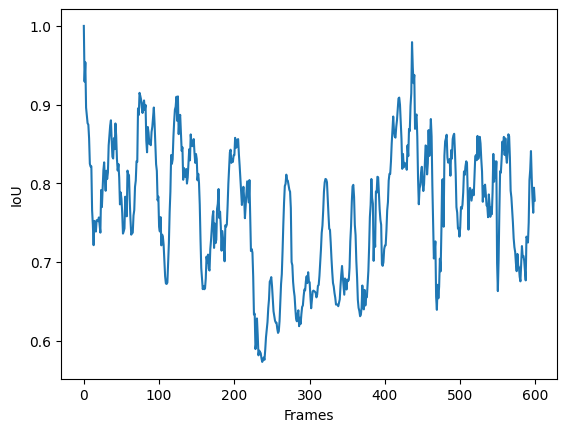

0.5728149137361661


In [2]:
error = inferencia('Drone3')
from matplotlib import pyplot as plt
plt.plot(error)
plt.xlabel("Frames")
plt.ylabel("IoU")
plt.show()
print(min(error))

ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with clang version 10.0.0
  configuration: --prefix=/Users/distiller/miniconda3/conda-bld/ffmpeg_1597180257571/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold --cc=x86_64-apple-darwin13.4.0-clang --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
In

load checkpoint from local path: ./siamese_rpn_r50_1x_lasot_20211203_151612-da4b3c66.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 600/600, 2.7 task/s, elapsed: 221s, ETA:     0s
 making the output video at ./Bikeinference.mp4 with a FPS of 60.0
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 600/600, 80.2 task/s, elapsed: 7s, ETA:     0s


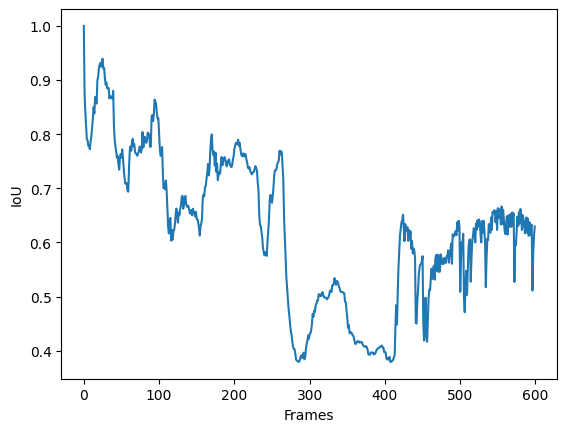

0.3792781333738964


In [3]:
error = inferencia('Bike')
from matplotlib import pyplot as plt
plt.plot(error)
plt.xlabel("Frames")
plt.ylabel("IoU")
plt.show()
print(min(error))

ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with clang version 10.0.0
  configuration: --prefix=/Users/distiller/miniconda3/conda-bld/ffmpeg_1597180257571/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold --cc=x86_64-apple-darwin13.4.0-clang --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
In

load checkpoint from local path: ./siamese_rpn_r50_1x_lasot_20211203_151612-da4b3c66.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 600/600, 3.0 task/s, elapsed: 203s, ETA:     0s
 making the output video at ./Alladininference.mp4 with a FPS of 60.0
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 600/600, 84.2 task/s, elapsed: 7s, ETA:     0s


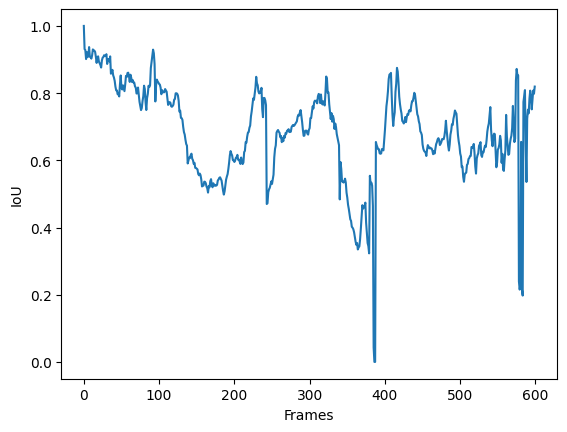

0.0


In [4]:
error = inferencia('Alladin')
from matplotlib import pyplot as plt
plt.plot(error)
plt.xlabel("Frames")
plt.ylabel("IoU")
plt.show()
print(min(error))

In [9]:
sorted(error)[0:5] # 2 frames perdidos

[0.0, 0.0, 0.043227656139696445, 0.19750038265633918, 0.21529814017417467]

ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with clang version 10.0.0
  configuration: --prefix=/Users/distiller/miniconda3/conda-bld/ffmpeg_1597180257571/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold --cc=x86_64-apple-darwin13.4.0-clang --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
In

load checkpoint from local path: ./siamese_rpn_r50_1x_lasot_20211203_151612-da4b3c66.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 600/600, 2.9 task/s, elapsed: 205s, ETA:     0s
 making the output video at ./Badminton1inference.mp4 with a FPS of 60.0
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 600/600, 76.2 task/s, elapsed: 8s, ETA:     0s


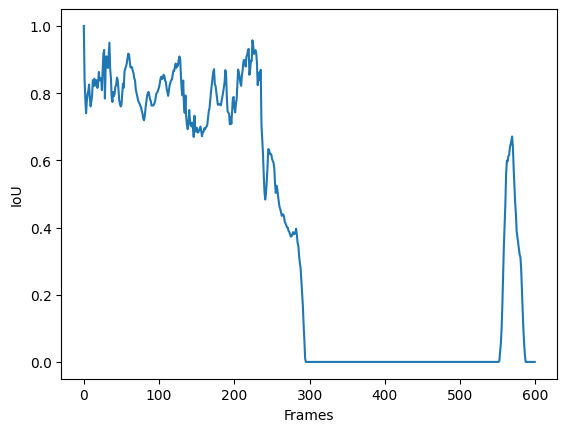

0.0


In [10]:
error = inferencia('Badminton1')
from matplotlib import pyplot as plt
plt.plot(error)
plt.xlabel("Frames")
plt.ylabel("IoU")
plt.show()
print(min(error))

ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with clang version 10.0.0
  configuration: --prefix=/Users/distiller/miniconda3/conda-bld/ffmpeg_1597180257571/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold --cc=x86_64-apple-darwin13.4.0-clang --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
In

load checkpoint from local path: ./siamese_rpn_r50_1x_lasot_20211203_151612-da4b3c66.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 600/600, 3.0 task/s, elapsed: 201s, ETA:     0s
 making the output video at ./Puppies1inference.mp4 with a FPS of 60.0
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 600/600, 83.3 task/s, elapsed: 7s, ETA:     0s


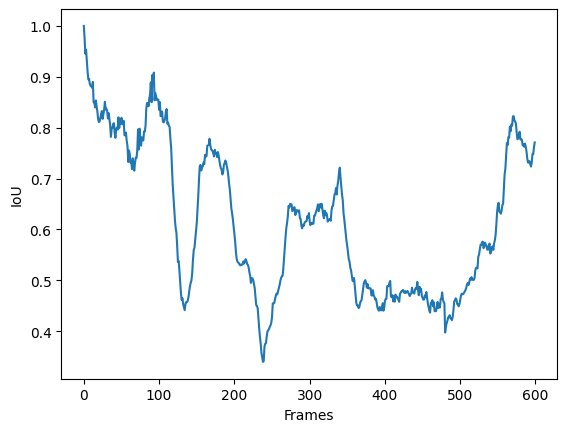

0.33972153499885016


In [11]:
error = inferencia('Puppies1')
from matplotlib import pyplot as plt
plt.plot(error)
plt.xlabel("Frames")
plt.ylabel("IoU")
plt.show()
print(min(error))

ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with clang version 10.0.0
  configuration: --prefix=/Users/distiller/miniconda3/conda-bld/ffmpeg_1597180257571/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold --cc=x86_64-apple-darwin13.4.0-clang --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
In

load checkpoint from local path: ./siamese_rpn_r50_1x_lasot_20211203_151612-da4b3c66.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 600/600, 2.7 task/s, elapsed: 222s, ETA:     0s
 making the output video at ./Helicopterinference.mp4 with a FPS of 60.0
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 600/600, 88.5 task/s, elapsed: 7s, ETA:     0s


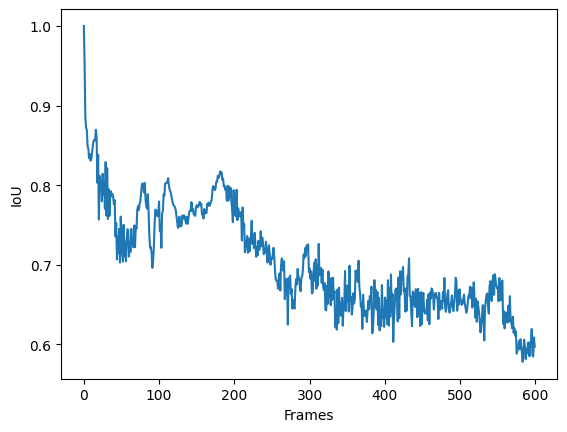

0.5779083568794792


In [12]:
error = inferencia('Helicopter')
from matplotlib import pyplot as plt
plt.plot(error)
plt.xlabel("Frames")
plt.ylabel("IoU")
plt.show()
print(min(error))

ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with clang version 10.0.0
  configuration: --prefix=/Users/distiller/miniconda3/conda-bld/ffmpeg_1597180257571/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold --cc=x86_64-apple-darwin13.4.0-clang --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
In

load checkpoint from local path: ./siamese_rpn_r50_1x_lasot_20211203_151612-da4b3c66.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 600/600, 2.6 task/s, elapsed: 228s, ETA:     0s
 making the output video at ./DriftCar1inference.mp4 with a FPS of 60.0
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 600/600, 93.0 task/s, elapsed: 6s, ETA:     0s


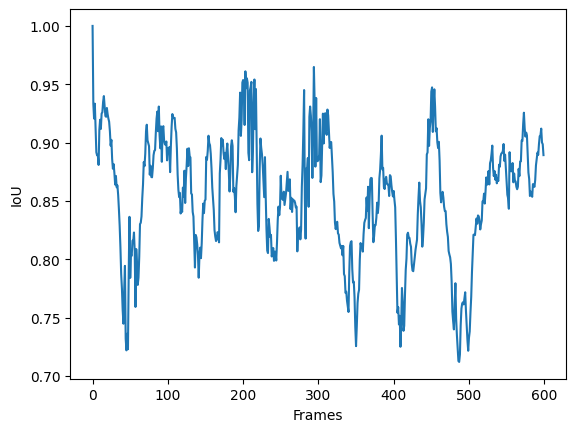

0.7119748032955616


In [13]:
error = inferencia('DriftCar1')
from matplotlib import pyplot as plt
plt.plot(error)
plt.xlabel("Frames")
plt.ylabel("IoU")
plt.show()
print(min(error))

ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with clang version 10.0.0
  configuration: --prefix=/Users/distiller/miniconda3/conda-bld/ffmpeg_1597180257571/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold --cc=x86_64-apple-darwin13.4.0-clang --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
In

load checkpoint from local path: ./siamese_rpn_r50_1x_lasot_20211203_151612-da4b3c66.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 600/600, 2.7 task/s, elapsed: 226s, ETA:     0s
 making the output video at ./ISSinference.mp4 with a FPS of 60.0
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 600/600, 73.0 task/s, elapsed: 8s, ETA:     0s


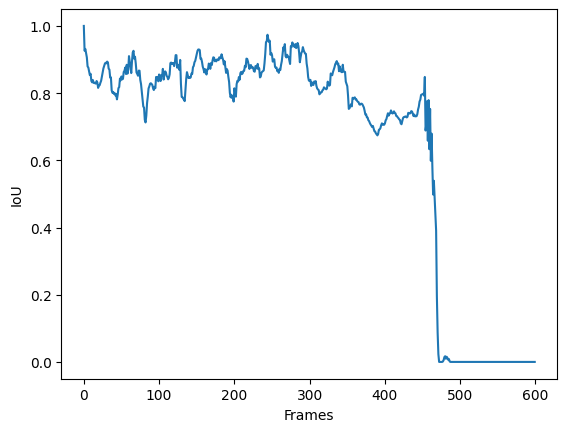

0.0


In [14]:
error = inferencia('ISS')
from matplotlib import pyplot as plt
plt.plot(error)
plt.xlabel("Frames")
plt.ylabel("IoU")
plt.show()
print(min(error))

ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with clang version 10.0.0
  configuration: --prefix=/Users/distiller/miniconda3/conda-bld/ffmpeg_1597180257571/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold --cc=x86_64-apple-darwin13.4.0-clang --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
In

load checkpoint from local path: ./siamese_rpn_r50_1x_lasot_20211203_151612-da4b3c66.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 600/600, 2.8 task/s, elapsed: 214s, ETA:     0s
 making the output video at ./ZebraFishinference.mp4 with a FPS of 60.0
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 600/600, 92.7 task/s, elapsed: 6s, ETA:     0s


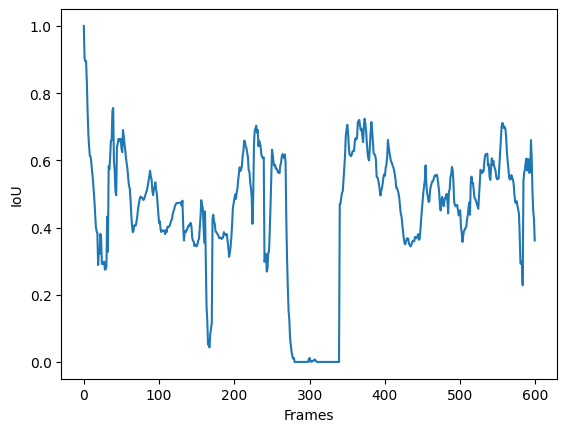

0.0


In [15]:
error = inferencia('ZebraFish')
from matplotlib import pyplot as plt
plt.plot(error)
plt.xlabel("Frames")
plt.ylabel("IoU")
plt.show()
print(min(error))